In [3]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from empath import Empath

In [4]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [5]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv'
df = pd.read_csv(file_path)

# Define the hypotheses and encode them
hypotheses = [
    "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
    "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
    "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
    "Surveillance cameras make people feel more secure rather than feeling watched.",
    "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
]

In [6]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583766,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
hypothesis_embeddings = model.encode(hypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis-embeddings.pkl', 'wb') as f:
    torch.save(hypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [82]:
# Load saved embeddings
hypothesis_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis-embeddings.pkl')

In [11]:
column = "thread_text_processed"
# column = "combined_processed"

In [84]:

texts = df[column].tolist()

# Generate embeddings in batches
batch_size = 10000
embeddings = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch_texts = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, device=device).cpu()
    embeddings.append(batch_embeddings)

# Concatenate all batches
embeddings = torch.cat(embeddings, dim=0)

# Save text embeddings
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-embeddings.pkl', 'wb') as f:
    torch.save(embeddings, f)

In [17]:
# Load saved embeddings
embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-embeddings.pkl')

In [8]:
# Initialize Empath
empath = Empath()
# Function to calculate empath categories
def get_empath_categories(text):
    categories = empath.analyze(text)
    return np.array([categories[cat] for cat in empath.cats.keys()])

In [13]:
# Calculate empath embeddings for hypotheses
hypothesis_empath_embeddings = np.array([get_empath_categories(hypothesis) for hypothesis in hypotheses])

# Save hypothesis empath embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_empath_embeddings.pkl', 'wb') as f:
    pickle.dump(hypothesis_empath_embeddings, f)

In [14]:
# Calculate empath embeddings for the dataset
empath_embeddings = []
tqdm.pandas(desc="Processing Empath Embeddings")
for empath_embedding in df['thread_text_processed'].progress_apply(lambda x: get_empath_categories(x)):
    empath_embeddings.append(empath_embedding)

# Save the empath embeddings to a file
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-empath_embeddings.pkl', 'wb') as f:
    pickle.dump(empath_embeddings, f)

In [ ]:
# Load saved embeddings
hypothesis_empath_embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_empath_embeddings.pkl')

empath_embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-empath_embeddings.pkl')

In [15]:
# Function to assign hypothesis based on both text and empath embeddings
def assign_hypothesis(text_embedding, empath_embedding, margin=0.03):
    text_similarities = cosine_similarity([text_embedding], hypothesis_embeddings).flatten()
    sorted_similarities = np.sort(text_similarities)[::-1]
    
    if sorted_similarities[0] - sorted_similarities[1] <= margin:
        empath_similarities = cosine_similarity([empath_embedding], hypothesis_empath_embeddings).flatten()
        combined_similarities = (text_similarities + empath_similarities) / 2
        return np.argmax(combined_similarities)
    return np.argmax(text_similarities)

In [18]:
# Assign hypotheses
tqdm.pandas(desc="Assigning Hypotheses")
hypothesis_labels = {i: f'H{i}' for i in range(len(hypotheses))}
df['hypothesis'] = [hypothesis_labels[assign_hypothesis(embeddings[i], empath_embeddings[i])] for i in tqdm(range(len(embeddings)))]


100%|██████████| 583771/583771 [06:37<00:00, 1466.85it/s]


In [19]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,hypothesis
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...,H2
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...,H2
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...,H0
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...,H4
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...,H4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583766,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,H2
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented,H2
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...,H2
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...,H2


hypothesis
H2    222834
H3    129563
H4     91385
H1     76353
H0     63636
Name: count, dtype: int64


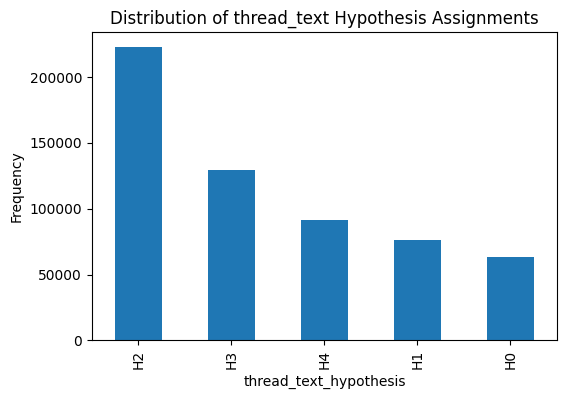

In [22]:
# Optional: Display a histogram of the assigned hypotheses
print(df['hypothesis'].value_counts())
df['hypothesis'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Distribution of thread_text Hypothesis Assignments')
plt.xlabel('thread_text_hypothesis')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Save the DataFrame with the hypothesis mapping
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_with_hypotheses.csv', index=False)